In [1]:
from model_utils import configuration as cnf
from analysis import restore_plots
from model_utils import initialisation as init
import sectors
import pyomo.environ as pyo

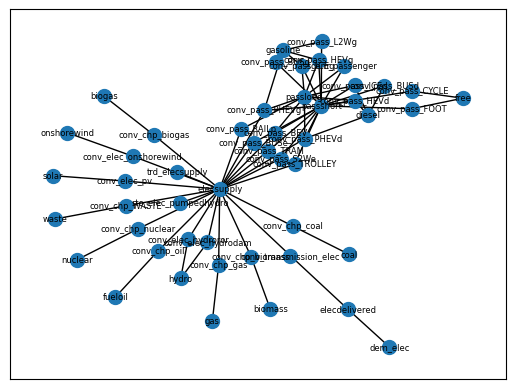

In [2]:
# Show network complexity
restore_plots.plot_io_network(cnf.DATA.fxe["FiE"], cnf.DATA.fxe["FoE"])

In [3]:
# Model setup
model = init.init_model()

sectors.trade.configure_sector(model)
sectors.extraction.configure_sector(model)
sectors.storage.configure_sector(model)

sectors.electricity.configure_sector(model)
sectors.transmission.configure_sector(model)
sectors.passenger.configure_sector(model)

sectors.demands.configure_sector(model)

In [4]:
# Investment cost
def e_costinv_p_y(model, process, year):
    if process in model.Caps:
        cost_inv = cnf.DATA.get_fxe(process, "cost_investment", year)
        return model.DR[year]*cost_inv*model.cnew[process,year]
    return pyo.Expression.Skip

def e_costinv_y(model, year):
    return sum(model.e_costinv_p_y[p, y] for p,y in model.e_costinv_p_y if y == year)

def e_costinv(model):
    return sum(model.e_costinv_y[y] for y in model.e_costinv_y)

model.e_costinv_p_y = pyo.Expression(model.Pros, model.Years, rule=e_costinv_p_y)
model.e_costinv_y = pyo.Expression(model.Years, rule=e_costinv_y)
model.e_costinv = pyo.Expression(rule=e_costinv)

In [5]:

def e_costfixedom_p_y(model, process, year):
    if process in model.Caps:
        cost_fom = cnf.DATA.get(process, "cost_fixed_om_annual", year)
        return model.DR[year]*cost_fom*model.ctot[process,year]
    return pyo.Expression.Skip

def e_costfixedom_y(model, year):
    return sum(model.e_costfixedom_p_y[p, y] for p,y in model.e_costfixedom_p_y if y == year)

def e_costfixedom(model):
    return sum(model.e_costfixedom_y[y] for y in model.e_costfixedom_y)

model.e_costfixedom_p_y = pyo.Expression(model.Pros, model.Years, rule=e_costfixedom_p_y)
model.e_costfixedom_y = pyo.Expression(model.Years, rule=e_costfixedom_y)
model.e_costfixedom = pyo.Expression(rule=e_costfixedom)

In [6]:
def e_costvar_p_y_h(model, process, year, hour):
    # Variable cost is type-dependent to improve readability at the database-level.
    d_f = model.DR[year]
    cost = 0
    if process in model.Trades:
        if process not in model.TradesImp:
            return pyo.Expression.Skip
        cost_var = cnf.DATA.get(process, "cost_import", year)
        cost = d_f*cost_var*model.aimp[process, year, hour]
    else:
        cost_var = cnf.DATA.get(process, "cost_variable_om", year)
        cost = d_f*cost_var*model.a[process, year, hour]
    return cost if not isinstance(cost, (int, float)) else pyo.Expression.Skip

def e_costvar_y(model, year):
    return model.TPERIOD * sum(model.e_costvar_p_y_h[p,y,h] for p,y,h in model.e_costvar_p_y_h if y == year)

def e_costvar(model):
    return sum(model.e_costvar_y[y] for y in model.e_costvar_y)

model.e_costvar_p_y_h = pyo.Expression(model.Pros, model.Years, model.Hours, rule=e_costvar_p_y_h)
model.e_costvar_y = pyo.Expression(model.Years, rule=e_costvar_y)
model.e_costvar = pyo.Expression(rule=e_costvar)

In [7]:
def e_revenuevar_p_y_h(model, process, year, hour):
    # Variable cost is type-dependent to improve readability at the database-level.
    if process in model.TradesExp:
        discount_f = model.DR[year]
        rev_var = cnf.DATA.get(process, "revenue_export", year)
        return discount_f*rev_var*model.aexp[process, year, hour]
    return pyo.Expression.Skip

def e_revenuevar_y(model, year):
    return model.TPERIOD * sum(model.e_revenuevar_p_y_h[p,y,h] for p,y,h in model.e_revenuevar_p_y_h if y == year)

def e_revenuevar(model):
    return sum(model.e_revenuevar_y[y] for y in model.e_revenuevar_y)

model.e_revenuevar_p_y_h = pyo.Expression(model.Pros, model.Years, model.Hours, rule=e_revenuevar_p_y_h)
model.e_revenuevar_y = pyo.Expression(model.Years, rule=e_revenuevar_y)
model.e_revenuevar = pyo.Expression(rule=e_revenuevar)

In [8]:
tot_cost_expr = model.e_costinv + model.e_costfixedom + model.e_costvar - model.e_revenuevar
model.cost = pyo.Objective(expr=tot_cost_expr, sense=pyo.minimize)
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

opt = pyo.SolverFactory("gurobi", solver_io="python")
opt.options["MIPGap"] = 1e-2
opt.options["Timelimit"] = 1800
try:
    opt_result = opt.solve(model, tee=False)
    print(opt_result)
except ValueError:
    model.write("debug.lp", format="lp", io_options={"symbolic_solver_labels": True})


Problem: 
- Name: unknown_copy
  Lower bound: 422467318117.3732
  Upper bound: 422467318117.3732
  Number of objectives: 1
  Number of constraints: 107276
  Number of variables: 105480
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 105480
  Number of nonzeros: 318416
  Sense: 1
  Number of solutions: 1
Solver: 
- Name: Gurobi 9.52
  Status: ok
  Wallclock time: 2.793365001678467
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



# Plotting

In [ ]:
for y in model.Years:
    population = cnf.DATA.get_annual("country", "actual_population", y)
    daily_time = cnf.DATA.get_annual("country", "daily_travel_time", y)
    ttb = population * daily_time * 365
    print(ttb,sum(
        model.TPERIOD * 1e6 * sum(model.fout[f, e, y, h].value for h in model.Hours) /
        cnf.DATA.get_fxe(e, "speed", f, y)
        for f, e in model.PassTransFoE))

<AxesSubplot:title={'center':"Modelled:Input:['passshort', 'passlong']"}, ylabel='TWh'>

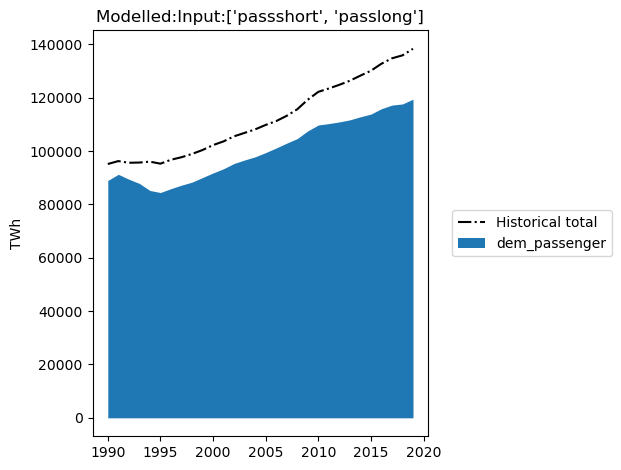

In [9]:
restore_plots.plot_aggregated_fin(model, cnf.DATA, ["passshort", "passlong"], unit="TWh", hist="passenger")

<AxesSubplot:title={'center':"Modelled:Output:['elecsupply']"}, ylabel='Mpkm'>

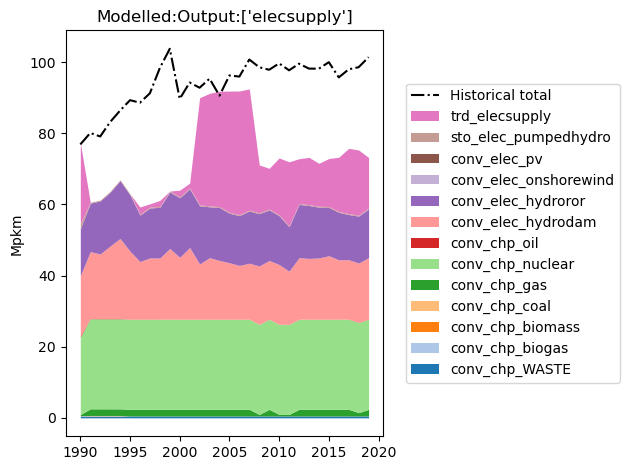

In [14]:
restore_plots.plot_aggregated_fout(model, cnf.DATA, ["elecsupply"], unit="Mpkm", hist="elecsupply")

<AxesSubplot:title={'center':"Modelled:Output:['passlong', 'passshort']"}, ylabel='Mpkm'>

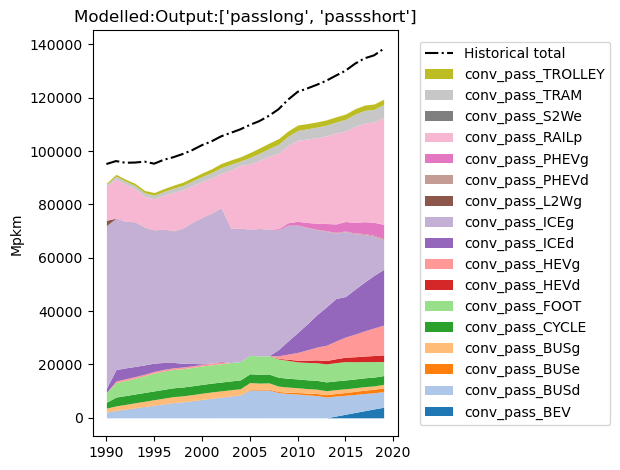

In [11]:
restore_plots.plot_aggregated_fout(model, cnf.DATA, ["passlong", "passshort"], unit="Mpkm", use_actual=False,
                                   hist="passenger")

In [ ]:
restore_plots.plot_aggregated_ctot(model, cnf.DATA, ["conv_pass"], "units", use_actual=False)

In [ ]:
restore_plots.plot_aggregated_ctot(model, cnf.DATA, ["conv_pass"], "units", use_actual=True)

# Debug
Check your model run :)

In [ ]:
[e for e in model.Elems if "passenger" in e and e in model.Caps]

In [ ]:
from pyomo.util import infeasible
infeasible.log_infeasible_constraints(model, log_expression=True, log_variables=True)
infeasible.log_infeasible_bounds(model)
# infeasible.log_close_to_bounds(model)

In [ ]:
import gurobi

model.write("debug.lp", format="lp", io_options={"symbolic_solver_labels": True})
m = gurobi.read("debug.lp")
m.optimize()
m.computeIIS()
m.write("debug_{0}.ilp".format("CHE"))